In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# K-Means

### K-Means 的演算過程:
* 先隨機從資料中選出K個instance 作為初始的cluster centroid
* 重複以下操作, 直到各centroid的位置不再移動為止:
    * 將每筆資料指派給最靠近的centroid
    * 更新centroid位置為，新的centroid的位置為指派給該centroid的所有資料之平均


## 以下以iris 分類問題為例，示範如何使用scikit learn中的kmeans模組，對資料進行clustering

## 首先，先讀取sklearn內建的iris 資料集

In [3]:
data = load_iris()
x = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

## 畫出所有資料點，為了視覺化方便，只取第3及第4個特徵(通常在unsupervised learning的情景，不會有target值，這邊只是用來方便比較)

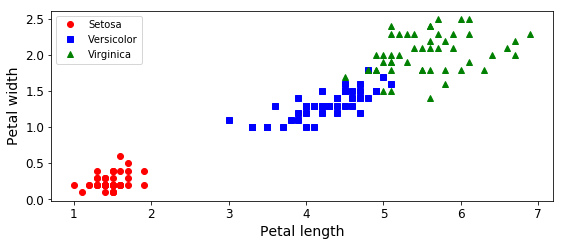

In [4]:
plt.figure(figsize=(9, 3.5))
plt.plot(x[y==0, 2], x[y==0, 3], "ro", label="Setosa")
plt.plot(x[y==1, 2], x[y==1, 3], "bs", label="Versicolor")
plt.plot(x[y==2, 2], x[y==2, 3], "g^", label="Virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend()
plt.show()

## scikit learn 中的KMeans 各參數的意義: (參考 https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html )
* n_clusters: 指定群聚的數量
* max_iter: 最大迭代次數
* n_init: 用不同初始化的centroids運行的次數，最後會從中選出一個最好的結果，default為10次
* init: 初始化的方式，有random 及 kmeans++ 兩種，詳見上述連結說明
* algorithm: "auto" "full" or "elkan"，用預設的"auto"即可 

In [5]:
k = 3

kmeans = KMeans(n_clusters=k, random_state=42)
clusters_pred = kmeans.fit_predict(x)

## inertia: within cluster sum of squres, 各sample到各該群的centroid的距離之平方和，用來評估cluster的成效，越大代表越差

In [7]:
kmeans.inertia_

78.94084142614602

## 查看各cluster的中心，並在圖上畫出

In [9]:
kmeans.cluster_centers_

array([[5.9016129 , 2.7483871 , 4.39354839, 1.43387097],
       [5.006     , 3.418     , 1.464     , 0.244     ],
       [6.85      , 3.07368421, 5.74210526, 2.07105263]])

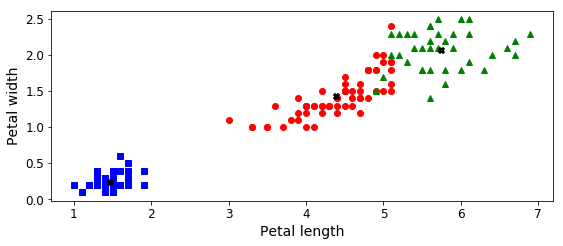

In [9]:
plt.figure(figsize=(9, 3.5))
plt.plot(x[clusters_pred==0, 2], x[clusters_pred==0, 3], "ro", label="Iris-Setosa")
plt.plot(x[clusters_pred==1, 2], x[clusters_pred==1, 3], "bs", label="Iris-Versicolor")
plt.plot(x[clusters_pred==2, 2], x[clusters_pred==2, 3], "g^", label="Iris-Virginica")
plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 3], color='k', marker='X', zorder=5)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.show()

## 雖然跟ground truth 相比結果雖然有一點差異，但確實有達到clustering的效果

## 如何決定K? 可用inertia做評估。以下利用scikit learn的make_blobs建立一個有四個中心的共2000筆的假資料作為範例:

In [11]:
# 先指定centroids的位置及各cluster的標準差
blob_centers = np.array(
    [[ -0.2,  2.3],
     [1.5 ,  2.3],
     [2.8,  2.8],
     [2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1])

In [12]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

Text(0,0.5,'$x_2$')

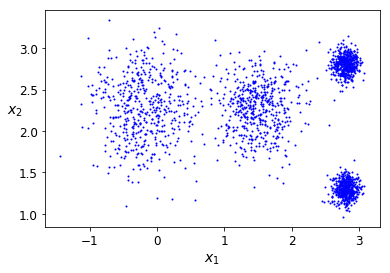

In [14]:
plt.scatter(X[:, 0], X[:, 1], c='b', s=1)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)

## 想像你拿到這份資料集，沒有label, 也無法一眼看出有多少個中心的情況，想用kmeans clustering, 該怎麼決定K? 可用多個k值做實驗，並用各次實驗結果的inertia做評估

In [15]:
# k = 1~9 做九次kmeans, 並將每次結果的inertia收集在一個list裡
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

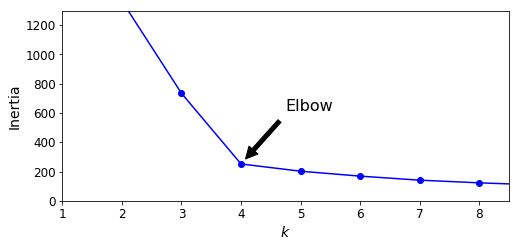

In [16]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])

plt.show()

## 如圖，當K值越來越大，inertia會隨之越來越小，(但k=n時理論上inertia會減為0, 因此實際上不能選inertia最小的那個k) 一般是取elbow point, 即inertia迅速下降轉為平緩的那個點

## 另外一個方法是用silhouette scores 去評估. 
### The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score)
## Silhouette Coefficient 越大代表分群效果越好

In [19]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

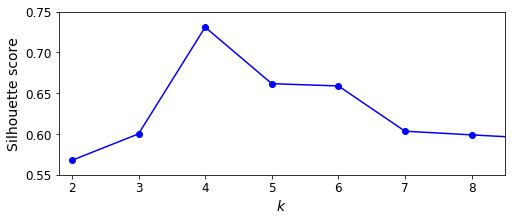

In [20]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.75])

plt.show()

## 以圖中的結果來看應選擇k=4, 5也可以試試看